# comparing particle number distributions of particle model to full models
Tim Tyree<br>
6.6.2025

In [1]:
# !conda env list
import sys
print(sys.executable)
# /Users/timothytyree/opt/miniconda3/envs/pyenv_bgmc/bin/python

/Users/timothytyree/opt/miniconda3/envs/pyenv_bgmc/bin/python


In [2]:
from lib.my_initialization import *

In [3]:
import seaborn as sns
#reset matplotlib
plt.plot([1]*4)
plt.close()
#reset matplotlib settings
import matplotlib as mpl
sns.reset_orig()
mpl.rc_file_defaults()

In [4]:
import scipy

In [5]:
from lib.utils.parse_tip_pos import *

# define module

In [6]:
# @njit
def format_particles(frameno,t,x_values,y_values,pid_values,round_t_to_n_decimals=5,tscale=1000):
    '''tscale scales from seconds to milliseconds.
    round_t_to_n_decimals=5 corrects arithmatic error, minimizes output memory requirements, and matches Dt=dt=1e-5 seconds
    '''
    n_tips = x_values.shape[0]
    dict_out = {
        'frame':frameno,
        't': np.around(t,round_t_to_n_decimals)*tscale,
        'n': n_tips,
        'x': x_values,
        'y': y_values,
        'pid_explicit':pid_values}
    return dict_out

In [7]:
import numpy as np, pandas as pd, os, sys
# from numba import njit

# @njit
def sqdiff(x1, x2):
    return pow((x1-x2),2)

# @njit
def min3(num1, num2, num3):
    if (num1 > num2 ):
        mn=num2
    else:
        mn=num1
    if (mn>num3):
        mn=num3
    return mn

# @njit
def dist_pbc(x1, y1, x2, y2, L):
    # returns the smallest dist of each possible pbc combination
    xsq1 = sqdiff(x1,x2)
    xsq2 = sqdiff(x1,x2+L)
    xsq3 = sqdiff(x1,x2-L)
    ysq1 = sqdiff(y1,y2)
    ysq2 = sqdiff(y1,y2+L)
    ysq3 = sqdiff(y1,y2-L)
    xsq  = min3(xsq1,xsq2,xsq3)
    ysq  = min3(ysq1,ysq2,ysq3)
    return np.sqrt(xsq+ysq)

# @njit
def subtract_pbc_1d(x1, x2, L):
    # returns the smallest dist of each possible pbc combination
    dx = x1-x2
    dx1 = x1-x2+L
    dx2 = x1-x2-L
    if (abs(dx1)<abs(dx)):
        dx=dx1;
    else:
        if (abs(dx2)<abs(dx)):
            dx=dx2
    return dx

# @njit
def reflection(X, L):
  return L-abs(L-abs(X % 2.*L))
# @njit
def periodic(X, L):
  x=X % L
  if (x<0.):
    return x+L
  return x


def seed_new_particle(x_new,y_new,still_running,L,R_c_bar,max_num_retries=100):
    """
    Example Usage:
xg,yg=seed_new_particle(x_new,y_new,still_running,L,R_c_bar,max_num_retries=100)
    """
    xg=np.random.uniform(0,1)*L
    yg=np.random.uniform(0,1)*L
    mindist=2.*L
    for j in np.argwhere(still_running).flatten():
        dist=dist_pbc(xg,yg,x_new[j],y_new[j],L);
        if dist<mindist:
            mindist=dist
    #while new particle is within distance R_c_bar from any other particle
    num=0
    while (mindist<R_c_bar) and (num<max_num_retries):
        num+=1
        xg=np.random.uniform(0,1)*L
        yg=np.random.uniform(0,1)*L
        mindist=2.*L
        for j in np.argwhere(still_running).flatten():
            dist=dist_pbc(xg,yg,x_new[j],y_new[j],L);
            if dist<mindist:
                mindist=dist
    return xg,yg

def  gener_termination_time_log(seed,Ninitial=2,Nfinal=0,
                            chi=2.08,
                            R_c_bar=0.6667, #cm
                            kappa=75, #Hz
                            r=0.314, #cm
                            varkappa=9.3, #cm^2/s
                            D=0.42, #cm^2/s
                            Mp = 3.28, #+/- 0.10 Hz/cm^2;
                            nup = 0.715, #+/- 0.010
                            r0=0.202,
                            L=5,
                            creation_duration = 0.1, #s 0.0025, # 0.001 #s  #
                            Dt=1e-5,dt=1e-5,
                            no_repulsion=0,no_attraction=0,
#                             save_every=5,
                            save_every=int(1e-1/1e-5),
                            tmax=60, #s
                            epsilon=5e-2,  #reactions happen immediately at this range
                            x0=5,  #skipping reflect,set_second, and neighbor functionality
                            N=150, #max number of particles
                            force_code=2,
                            dist_cutoff=1e-2,
                            use_creation=True,
                            use_pair_create=True,
                            use_set_created_from_existing=True,
                            use_uniform_ic=False,
                            show_movie=False,#True,
#                             recording_locations=False,#True,
                            recording_locations=True,
                            recording_snapshots=False,#True,
                            printing=False,
                          **kwargs):
    """
    src: http://localhost:8889/notebooks/implementing%20creation%20events.ipynb
    modified to produce particle number distributions.
    Example Usage:
dictt = gener_termination_time_log(seed,Ninitial=2,Nfinal=0,
                            chi=chi,kappa=kappa, #Hz
                            r=r, #cm
                            varkappa=varkappa, #cm^2/s
                            D=D, #cm^2/s
                            Mp = Mp, # Hz/cm^2;
                            nup = nup,L=L,creation_duration = creation_duration, # 0.001 #s  # 0.1 #s
                            Dt=Dt,dt=dt,use_creation=True,use_pair_create=True,use_set_created_from_existing=True)
print(f"termination time: {t}")
    """
#     r0=r
#     r0=6e-2
#     tmax=500 #s
#     tmax=60 #s
#     epsilon=5e-2  #reactions happen immediately at this range
#     x0=5
#     #skipping reflect,set_second, and neighbor functionality
#     N=150 #max number of particles
    np.random.seed(seed)
    x_values=np.random.uniform(0,1,size=N)*L
    y_values=np.random.uniform(0,1,size=N)*L
    t=0
    if use_uniform_ic:
        Nrow=4
    #     Nrow=10
        #explicitely uniform ic.
        uvals=np.linspace(0,L*Nrow/(Nrow+1),Nrow)
        x_values,y_values=np.meshgrid(uvals,uvals)
        x_values=x_values.flatten()+L/(2*(Nrow+1))
        y_values=y_values.flatten()+L/(2*(Nrow+1))
        #explicitely enter ^these values in my c simulation and run it
        N = x_values.shape[0]

    #return a scatter plot that may be saved as png
    if show_movie:
        annotating=True
        message='initial positions'
        fig=ScatterPlotSnapshot(x_values,y_values,t,width=L,height=L,
                                annotating=annotating,message=message,inch=6)
        plt.show()

    if show_movie:
        #for snapshot output
        save_folder=f"{nb_dir}/Figures/mov"
        if os.path.exists(save_folder):
            #cleanse the old snapshot folder
            shutil.rmtree(save_folder)
        os.mkdir(save_folder)
        annotating=True
    frameno=1
    save_fn=None
    inch=6
#     # message='without forces'
#     # force_code=0
#     # varkappa=0
#     # message='with anti-spring forces'
#     # force_code=1
#     # varkappa=-5
# #     message='with particle creation'
#     force_code=2
#     dist_cutoff=1e-2

    # varkappa=1.552
    # message=f'with {alpha=}'
    message=' '
    stepscale=np.sqrt(2*D*Dt) #diffusive
    # stepscale=(2*D*Dt)**(1/alpha)
    probreact=kappa*dt
    A = L**2
    T_net=0;count_net=0
    # iter_per_movestep = round(Dt/dt)
    impulse_prefactor= varkappa * Dt
    tiarray=np.zeros(N)
    tfarray=np.zeros(N)
    step=0
    if printing:
        print("running simulation...");
    t=-Dt
    # still_running=True;
    exit_code=-1;T=-9999.
    #initialize positions
    # #uniform random ic
    # x_values=rs.uniform(size=N)*L
    # y_values=rs.uniform(size=N)*L
    # #explicitely uniform ic
    # uvals=np.linspace(0,L,5)
    # x_values,y_values=np.meshgrid(uvals,uvals)
    # x_values=x_values.flatten()
    # y_values=y_values.flatten()

    #lower case: world coordinates
    #upper case: material coordinates
#     x=x_values.copy()
#     y=y_values.copy()
    x_old=x_values.copy()
    y_old=y_values.copy()
    x_new=x_values.copy()
    y_new=y_values.copy()
#     X=x_values.copy()
#     Y=y_values.copy()
#     X_old=x_values.copy()
#     Y_old=y_values.copy()
#     X_new=x_values.copy()
#     Y_new=y_values.copy()




    zeros=np.zeros_like(x_values)
    zerosint=np.zeros_like(x_values).astype('int')
    # still_running=zerosint==zerosint
    still_running=zerosint!=zerosint
#     still_running[:Ninitial]=True  #initialize first Ninitial particles to still be running
    caught=zerosint.copy()-9999#!=zerosint
    anticaught=zerosint.copy()-9999#!=zerosint

    #create the initial particles
    for i in range(Ninitial):
        xg,yg=seed_new_particle(x_new,y_new,still_running,L,R_c_bar,max_num_retries=100)
        x_new[i]=xg
        y_new[i]=yg
        still_running[i]=True

    # //start set_second kernel
    # //end set_second kernel
    #make still_running into still_running_values
    dict_out_lst=[]
    # reset the net forces
    Fx_net=zeros.copy()
    Fy_net=zeros.copy()
    # while(still_running.any()):
    while(still_running.sum()>Nfinal):
        # //reinitialize_kernel, which copies X,Y_new to X,Y_old
        min_dist_old=zeros+9999999
        i_neighbor=zerosint-1
        x_old=x_new
        y_old=y_new
        t=t+Dt;
#         np.random.seed(seed) # didn't make it deterministic

        #sum_each_force_kernel
        for i in range(N):
            if(still_running[i]):
                for j in range(i+1,N):
                    if(still_running[j]):
                        #compute displacement vector with pbc
                        dx = subtract_pbc_1d(x_old[j],x_old[i],L);
                        dy = subtract_pbc_1d(y_old[j],y_old[i],L);
                        dist2=dx*dx+dy*dy;
                        if (dist2<1e-8):
                            dist2=float(1e-8)
                        dist = np.sqrt(dist2)
                        #compute displacement due to drift
                        impulse_factor=0.
                        if (force_code==1):
                          #spring
                          impulse_factor=impulse_prefactor*(dist-x0)/dist;
                        if (force_code==2):
                          #QED2: force ~ inverse power law
                          impulse_factor=impulse_prefactor/dist2;
                        if (force_code==3):
                          #QED3: force ~ inverse square power law
                          impulse_factor=impulse_prefactor/dist2/dist;
                        #set impulse_factor to zero if it is explicitly forbidden by the user input
                        if ((no_attraction==1) & (impulse_factor>0)):
                            impulse_factor=0.
                        if ((no_repulsion==1) & (impulse_factor<0)):
                            impulse_factor=0.
                        #sum Fx_net, Fy_net according to a symplectic (momentum conserving) integrator
                        Fx_net[i]=Fx_net[i]+dx*impulse_factor;
                        Fy_net[i]=Fy_net[i]+dy*impulse_factor;
                        Fx_net[j]=Fx_net[j]-dx*impulse_factor;
                        Fy_net[j]=Fy_net[j]-dy*impulse_factor
                        #determine if they are closer than epsilon
                        if dist<epsilon:
                            #remove if they are
                            still_running[i]=False
                            still_running[j]=False
                            uncatch_set=set()
                            if caught[i]>=0:
                                uncatch_set.update([caught[i]])
                                if caught[caught[i]]>=0:
                                    uncatch_set.update([caught[caught[i]]])
                            if caught[j]>=0:
                                uncatch_set.update([caught[j]])
                                if caught[caught[j]]>=0:
                                    uncatch_set.update([caught[caught[j]]])
                            if len(uncatch_set)>0:
                                for k in uncatch_set:
                                    caught[k]=-9999
        #compute the one_step given the net force, F_net
        for i in range(N):
            if(still_running[i]):
                if caught[i]<0:
                    dxt=Fx_net[i];
                    dyt=Fy_net[i];
                    # compute displacement due to levy flight
    #                 dxW,dyW = stepscale*levyRandom2D(alpha)
#                     dxW = stepscale*normalRandom()
#                     dyW = stepscale*normalRandom()
                    dxW = stepscale*np.random.normal()
                    dyW = stepscale*np.random.normal()
                    # next spatial position, time integrating by a duration, Dt. enforce PBC.
                    x_new[i]=periodic(x_old[i]+dxW+dxt,L);
                    y_new[i]=periodic(y_old[i]+dyW+dyt,L);
                else:
                    j=caught[i]
                    ti=tiarray[i]
                    tf=tfarray[i]
                    #compute displacement vector with pbc
                    dx = subtract_pbc_1d(x_old[j],x_old[i],L)
                    dy = subtract_pbc_1d(y_old[j],y_old[i],L)
                    xl = dx - (x_old[j]-x_old[i])
                    yl = dy - (y_old[j]-y_old[i])
                    #compute average location
                    xavg = x_old[i] + 0.5*dx
                    yavg = y_old[i] + 0.5*dy
                    #compute frac to interpolate by
                    frac = (t-ti)/(tf-ti)
                    frac = np.min((1,frac))
                    x_new[i] = periodic(x_old[i]*(1-frac) + (xavg+xl)*frac,L)
                    y_new[i] = periodic(y_old[i]*(1-frac) + (yavg+yl)*frac,L)
        #reaction_kernel
        for i in range(N):
            if(still_running[i]&(caught[i]<0)&(anticaught[i]<0)):
                # // each i,j pair is reached once per call to kernel_measure
                for j in range(i+1,N):
                    if(still_running[j]&(caught[j]<0)&(anticaught[j]<0)):
                        # // compute distance between particles that are still running
                        dist=dist_pbc(x_new[i],y_new[i],x_new[j],y_new[j],L);
                        in_range=dist<r;
                        # // in_range=true;//uncomment for smeared method
                        # // if two particles are in range
                        if(in_range):
                            # // determine whether those two particles react via the simple method
#                             reacts=probreact>uniformRandom();
                            reacts=probreact>np.random.uniform(0,1);
                            # // determine whether those two particles react via the smeared method
                            # // sig=sigmoid(dist, r, beta);
                            # // reacts=probreact*sig>uniformRandom();
                            if(reacts):
                                exit_code=1;
                                T=t;
    #                             still_running[i]=False;
    #                             still_running[j]=False;
                                #uncatch any previous catches
                                if caught[i]>=0: caught[caught[i]]=-9999
                                if caught[j]>=0: caught[caught[j]]=-9999
                                #catch these two
                                caught[i]=j;
                                caught[j]=i;
                                #determine deltat
                                deltat = dist**2/(4*(varkappa+2*D))
                                #determine ti,tf
                                tiarray[i]=t
                                tfarray[i]=t+deltat
                                tiarray[j]=t
                                tfarray[j]=t+deltat

        #determine rate_of_creation from average density
        num_particles = np.sum(still_running)
        prob_create = dt * Mp * (num_particles / A) ** nup * A
        #creation_kernel
        if not use_creation:
            prob_create=0
        if prob_create>np.random.uniform(0,1):
            if np.sum(~still_running)>=2:
                #select the first two particles that are removed
                igone=np.argwhere(~still_running)
                #reset/set their internal state
                caught[igone[0]]=-9999
                caught[igone[1]]=-9999
                anticaught[igone[0]]=igone[1]
                anticaught[igone[1]]=igone[0]
                tfarray[igone[0]]=t+creation_duration
                tfarray[igone[1]]=t+creation_duration

#                 #set their positions to 2 uniformly distributed positions
#                 x_new[igone[0]]=np.random.uniform(0,1)*L
#                 x_new[igone[1]]=np.random.uniform(0,1)*L
#                 y_new[igone[0]]=np.random.uniform(0,1)*L
#                 y_new[igone[1]]=np.random.uniform(0,1)*L

                #check if new particle is within distance R_c_bar from any other particles
                for ihere in igone[:2]:
                    xg,yg=seed_new_particle(x_new,y_new,still_running,L,R_c_bar,max_num_retries=1000)
                    x_new[ihere]=xg
                    y_new[ihere]=yg
                    still_running[ihere]=True

                #optionally set their positions to average a random location
                if use_pair_create:
#                     #optionally set their positions be a fixed distance to nearest tip
#                     if use_set_created_from_existing:
#                         #place a pair of particles uniformly on the circle of radius R_c_bar from a random particle
#                         xg,yg=gener_random_creation_position(x_new,y_new,still_running,R_c_bar,L)
#                         x_new[igone[0]] = xg
#                         y_new[igone[0]] = yg
                    theta=2*np.pi*np.random.uniform(0,1)
                    #heretim
                    x_new[igone[1]]=x_new[igone[0]] + 2.*r0*np.cos(theta)
                    y_new[igone[1]]=y_new[igone[0]] + 2.*r0*np.sin(theta)


        # reset the net forces
        Fx_net=zeros.copy()
        Fy_net=zeros.copy()
        #creation_force_kernel
        if use_pair_create:
            for i in range(N):
                if(still_running[i]&(anticaught[i]>=0)):
                    j = anticaught[i]
                    if still_running[j]:
                        #compute displacement vector with pbc
                        dx = subtract_pbc_1d(x_old[j],x_old[i],L);
                        dy = subtract_pbc_1d(y_old[j],y_old[i],L);
                        dist2=dx*dx+dy*dy;
                        if (dist2<1e-8):
                            dist2=float(1e-8)
                        dist = np.sqrt(dist2)
                        #compute displacement due to drift
                        impulse_factor=0.
                        if (force_code==1):
                          #spring
                          impulse_factor=impulse_prefactor*(dist-x0)/dist;
                        if (force_code==2):
                          #QED2: force ~ inverse power law
                          impulse_factor=impulse_prefactor/dist2;
                        if (force_code==3):
                          #QED3: force ~ inverse square power law
                          impulse_factor=impulse_prefactor/dist2/dist;
                        #set impulse_factor to zero if it is explicitly forbidden by the user input
                        if ((no_attraction==1) & (impulse_factor<0)):
                            impulse_factor=0.
                        if ((no_repulsion==1) & (impulse_factor>0)):
                            impulse_factor=0.
                        #account for double counting and then scale
                        impulse_factor*=0.5*chi
                        #sum Fx_net, Fy_net according to a symplectic (momentum conserving) integrator
                        Fx_net[i]=Fx_net[i]-dx*impulse_factor;
                        Fy_net[i]=Fy_net[i]-dy*impulse_factor;
                        Fx_net[j]=Fx_net[j]+dx*impulse_factor;
                        Fy_net[j]=Fy_net[j]+dy*impulse_factor

        #turn off creation array
        for i in range(N):
            if still_running[i] and anticaught[i]>=0:
                if t>tfarray[i]:
                    anticaught[i]=-9999

#         if show_movie:
        if True:
            if step%save_every==0:
                x_plot=x_new[still_running]
                y_plot=y_new[still_running]
#                 n_plot = sum(still_running)
                c_plot = np.array(['gray']*y_plot.shape[0])
                caugh=caught[still_running]
                for i in range(y_plot.shape[0]):
                    if caugh[i]>=0:
                        c_plot[i]='r'
                acaugh=anticaught[still_running]
                for i in range(y_plot.shape[0]):
                    if acaugh[i]>=0:
                        c_plot[i]='g'
                
                if recording_snapshots:
                    #save result as png
                    SaveScatterPlotSnapshot(x_plot,y_plot,t,
                                            c=c_plot,
                                            width=L,height=L,
                                    frameno=frameno,save_folder=save_folder,
                                    annotating=annotating,message=message)
        #             print(f"- saved pic at {frameno=}")
                if (recording_locations)&(x_plot.shape[0]>0):
                    pid_values = np.arange(x_values.shape[0])[still_running]
                    #append particle locations to log, dict_out_lst
                    dict_out=format_particles(frameno,t,x_plot,y_plot,pid_values=pid_values)
                    dict_out_lst.append(dict_out)

                frameno+=1

        #shut simulation down if it's taking too long...
        if (t>tmax):
            for i in range(N):
                still_running[i]=False;
                exit_code=-99;

        step+=1
        #end while running
    
    #record this trial
    if (exit_code>0):
        if (T>0.):
            T_net=T_net+T;
            count_net=count_net+1;

    if printing:
        print(f"simulation complete!")
        beep(1)

    if recording_locations:
        #for csv output
        data_folder=f"{nb_dir}/data/local_results/creation_test_paired"
        if not os.path.exists(data_folder):
            os.mkdir(data_folder)
        data_folder=data_folder+"/Log"
        if not os.path.exists(data_folder):
            os.mkdir(data_folder)
#         data_fn=f"pbc_seed_{seed}_fc_{force_code}_r_{r}_D_{D}_L_{L}_kappa_{kappa}_varkappa_{varkappa}_alpha_{alpha}_creatdur_{creation_duration}_chi_{chi}_log.csv"
        data_fn=f"pbc_seed_{seed}_fc_{force_code}_r_{r}_D_{D}_L_{L}_kappa_{kappa}_varkappa_{varkappa}_creatdur_{creation_duration}_chi_{chi}_log.csv"

    #save particle locations as csv
    if recording_locations:
        df = pd.concat([pd.DataFrame(dict_out) for dict_out in dict_out_lst])
        df.reset_index(inplace=True, drop=True)
        #save the recorded data
        os.chdir(data_folder)
        df.to_csv(data_fn, index=False)
        if printing:
            print('saved to:')
            print(os.path.abspath(data_fn))
    dictt=dict(t=t,dict_out_lst=dict_out_lst)
    return dictt

def print_dict(input_dict,*argv):
    for key in input_dict.keys():
        print(f"{key}={input_dict[key]}")
    # args=sorted(argv)
    # if len(args)>0:
    #     print(str_btwn)
    # type_dict=type(dict())
    for arg in sorted(argv):
        print(f'\n#{arg}')
        obj=input_dict[arg]
        if type(obj) is type(dict()):
            print_dict (obj)
        else:
            print(arg)

# dev

In [8]:
# import numpy as np
# Ninitial=2
# # niter=1500  #<<<--- run time is ominously long... just to generate the inputs... best avoid...
# # niter=150
# niter=100
# # niter=1
dt=1e-5
# Nmax=150
creation_duration=0.1 #seconds for both full models
L=5
# a (cm2/s) 1.552 ± 0.016 9.3 ±0.3
# % \textcolor{red}{$b=a(\chi -1)$}
# % b=10.0 +/- 0.5 cm^2/s (LR)
# % b=10.0399 +/- 0.4766 cm^2/s (LR)
# % 	- chi=2.0796 +/- 0.0542
# % b=3.01 +/- 0.08 cm^2/s (FK)
# % b=3.0122 +/- 0.0773 cm^2/s (FK)
# % 	- chi=2.9408 +/- 0.0508
def map_b_to_chi(b,a):
    x = b/a
    chi = x+1
    return chi

In [9]:
Dt=1e-5
dt=1e-5

# dev simulation of a large number of termination events of the particle model at the precise parameter settings used in the creation paper

In [10]:
#DONE: cp the parameters here
#DONE: cp the run.py simulation here
#DONE: modify the run.py simulation to compute (i) (independent) particle numbers and (ii) average run time

In [11]:
# a_values = np.concatenate([a_values,[1.552,9.3]]) #for FK,LR
# b_values = np.concatenate([b_values,[3.01,10.0]]) #for FK, 10.0 for LR


In [12]:
#             #FK
#             #.                      R_c_bar Mp nup                                r0
#             args=seed, Ninitial, 0, 0.85, 0.864, 0.230, chi, 15, 0.457, a, 0.115, 0.131, L, creation_duration, dt

#LR  #<-- takes too long
#.                      R_c_bar Mp nup                                r0
# args=seed, Ninitial, 0, 1.25, 3.28, 0.715, chi, 75, 0.314, a, 0.42, 0.202, L, creation_duration, dt
R_c_bar, Mp, nup = 1.25, 3.28, 0.715
kappa = 75
a = 9.3
D = 0.42
b = 10.0
r = 0.314
r0 = 0.202
chi = map_b_to_chi(b,a)
chi

2.075268817204301

In [13]:
#TODO: recall olde particle number distrib.

In [14]:
printing=True
use_save_df_to_parquet_by=True
use_save_df_to_parquet_by=False
#load fortranic tip positions
nb_dir_ = '/Users/timothytyree/Documents/GitHub/care/notebooks'
folder=f"{nb_dir_}/Data/from_wjr/positions_fk/200x200"
fn = 'tippos_per_c_001'
folder=f"{nb_dir_}/Data/from_wjr/positions_lr/200x200"
fn = 'tippos_per_001'
input_dir = os.path.join(folder,fn)
log_folder_parquet=f'{folder}/positions'
assert os.path.exists(input_dir)
if use_save_df_to_parquet_by:
    df_log=parse_fortranic_tip_pos(input_dir)
    #partition df_log into a folder of tip logs
    save_df_to_parquet_by(df_log,log_folder_parquet,by='trial_num',compression='snappy',index=None)
    print(f"saved to spiral tip positions to {log_folder_parquet=}")
    #determine width and height of the computational domain input the discretization
    width,height=df_log.describe().loc['max'][['x','y']].values.T
    del df_log
else:
    width=200
    height=200

In [15]:
N0=2
constrain_to_N0=True
t_lst=[]
nv_lst=[]
np.random.seed(42)
for fn in os.listdir(log_folder_parquet):
    try:
        trial_num = eval(fn.split('=')[1])
        # load tip position data
        g=load_parquet_by_trial_num(trial_num=trial_num,folder_parquet=log_folder_parquet)
        n_series = g.groupby(by='t')['n'].min()
        t0_values = n_series[n_series==N0].index.values
        tf = n_series.index.values.max()
        t_values = tf-t0_values
        if len(t_values)>0:
            #record
            t_lst.extend(t_values)
    #         nv = g.groupby('t')['n'].mean()[::100] #once every 100ms
            nv = g.groupby('t')['n'].mean()[::10] #once every 10ms
            nv = nv[nv%2==0]
            if constrain_to_N0:
                t0 = np.random.choice(t0_values)
                nv = nv[nv.index.values>=t0].copy()
            nv_lst.extend(nv)
    except IndexError as e:
        pass
        #print(f"IndexError for {fn}: {e}")
n_series.max()

14

In [16]:
# # g.groupby('t')['n'].mean()[::.index.values
# # np.random.choice(t0_values)
# t0_values
# n_series
# g
# nv
# t_values

In [17]:
#TODO: generate histogram for discrete distribution

In [18]:
# Navg 8.1±0.7 8.1 17.0 5.0±2.4 4.3 32.3

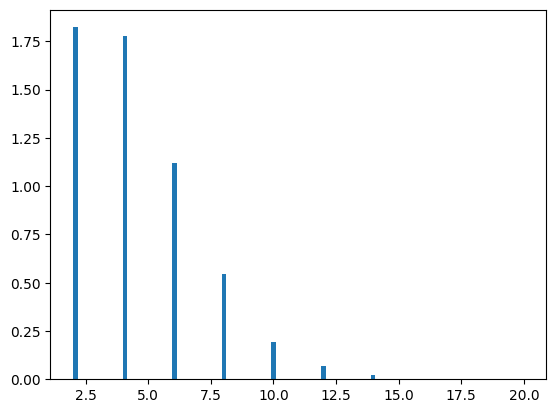

In [19]:
plt.hist(nv_lst,density=True,bins=100)
plt.show()

In [20]:
#print summary stats for distribution of particle numbers
nv_values = np.array(nv_lst)
meann,Delta_meann,num_obs,p_normal=comp_mean_bootstrap_uncertainty(nv_values)
print(f"{meann=},{Delta_meann=},{num_obs=},{p_normal=}")
median = np.median(nv_values)
q25 = np.quantile(nv_values,0.25)
q75 = np.quantile(nv_values,0.75)
print(f"median: {median} (IQR: {q25}-{q75}, N={nv_values.shape[0]})")

meann=4.500925583117364,Delta_meann=0.0382467670860806,num_obs=16206,p_normal=0.8887600482731572
median: 4.0 (IQR: 2.0-6.0, N=16206)


In [21]:
nv_values = np.array(nv_lst)
# np.random.choice(nv_values)
print(f"running simulation...")

running simulation...


In [22]:
nv_lst_parti = []
nobs_full = nv_values.shape[0]
nobs_parti = len(nv_lst_parti)
seed = 0
np.random.seed(seed)
while nobs_parti<nobs_full:
    seed+=1
#     Ninitial = int(np.random.choice(nv_values))
    Ninitial = N0 # 2
    dictt = gener_termination_time_log(seed,Ninitial=Ninitial,Nfinal=0,
                            save_every=int(1e-2/1e-5),
                            chi=chi,kappa=kappa, #Hz
                            r=r, #cms
                            varkappa=a, #cm^2/s
                            D=D, #cm^2/s
                            Mp = Mp, # Hz/cm^2;
                            nup = nup,L=L,creation_duration = creation_duration, # 0.001 #s  # 0.1 #s
                            Dt=Dt,dt=dt,use_creation=True,use_pair_create=True,use_set_created_from_existing=True)
    t=dictt['t']
    dict_out_lst= dictt['dict_out_lst']
    df = pd.concat([pd.DataFrame(dict_out) for dict_out in dict_out_lst])
    df.reset_index(inplace=True, drop=True)
    df = df[df['n']%2==0].copy()
    nv_lst_parti.extend(df.groupby(by='frame')['n'].max().values)
    nobs_parti = len(nv_lst_parti)
    print(f"termination time: {t:.4f} seconds ({nobs_parti/nobs_full:.2%} obs made) ({Ninitial=}) \r", end="")

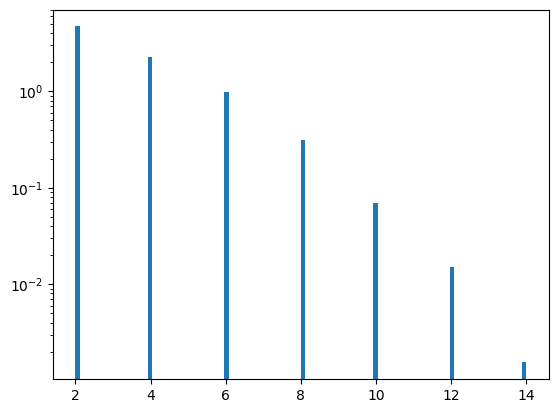

In [23]:
plt.hist(nv_lst_parti,bins=100, density=True)
plt.yscale('log')
plt.show()

In [24]:
beep(3)

-n 
-n 
-n 


0

In [25]:
#print summary stats for distribution of particle numbers
nv_values_parti = np.array(nv_lst_parti)
meann,Delta_meann,num_obs,p_normal=comp_mean_bootstrap_uncertainty(nv_values_parti)
print(f"{meann=},{Delta_meann=},{num_obs=},{p_normal=}")
median = np.median(nv_values_parti)
q25 = np.quantile(nv_values_parti,0.25)
q75 = np.quantile(nv_values_parti,0.75)
print(f"median: {median} (IQR: {q25}-{q75}, N={nv_values_parti.shape[0]})")

meann=3.3226900080133146,Delta_meann=0.02789410682996014,num_obs=16223,p_normal=0.29639117034878815
median: 2.0 (IQR: 2.0-4.0, N=16223)


In [26]:
scipy.stats.mannwhitneyu(nv_values_parti,nv_values)

MannwhitneyuResult(statistic=93653632.0, pvalue=0.0)

In [27]:
scipy.stats.kstest(nv_values_parti,nv_values)

KstestResult(statistic=0.23567906360390228, pvalue=0.0)

# repeat for FK model

In [28]:
#LR  #<-- takes too long
#.                      R_c_bar Mp nup                                r0
# args=seed, Ninitial, 0, 1.25, 3.28, 0.715, chi, 75, 0.314, a, 0.42, 0.202, L, creation_duration, dt

#             #FK
#             #.                      R_c_bar Mp nup                                r0
#             args=seed, Ninitial, 0, 0.85, 0.864, 0.230, chi, 15, 0.457, a, 0.115, 0.131, L, creation_duration, dt
R_c_bar, Mp, nup = 0.85, 0.864, 0.230
kappa = 15
r = 0.457
a = 1.552
D = 0.115
b = 3.01
r0 = 0.131
chi = map_b_to_chi(b,a)
chi

2.9394329896907214

In [29]:
printing=True
use_save_df_to_parquet_by=True
use_save_df_to_parquet_by=False
#load fortranic tip positions
nb_dir_ = '/Users/timothytyree/Documents/GitHub/care/notebooks'
folder=f"{nb_dir_}/Data/from_wjr/positions_fk/200x200"
fn = 'tippos_per_c_001'
# folder=f"{nb_dir_}/Data/from_wjr/positions_lr/200x200"
# fn = 'tippos_per_001'
input_dir = os.path.join(folder,fn)
log_folder_parquet=f'{folder}/positions'
assert os.path.exists(input_dir)
if use_save_df_to_parquet_by:
    df_log=parse_fortranic_tip_pos(input_dir)
    #partition df_log into a folder of tip logs
    save_df_to_parquet_by(df_log,log_folder_parquet,by='trial_num',compression='snappy',index=None)
    print(f"saved to spiral tip positions to {log_folder_parquet=}")
    #determine width and height of the computational domain input the discretization
    width,height=df_log.describe().loc['max'][['x','y']].values.T
    del df_log
else:
    width=200
    height=200

In [30]:
#TODO: see if conditioning on N0=2 helps
#heretim

In [31]:
N0=2
constrain_to_N0=True
t_lst=[]
nv_lst=[]
np.random.seed(42)
for fn in os.listdir(log_folder_parquet):
    try:
        trial_num = eval(fn.split('=')[1])
        # load tip position data
        g=load_parquet_by_trial_num(trial_num=trial_num,folder_parquet=log_folder_parquet)
        n_series = g.groupby(by='t')['n'].min()
        t0_values = n_series[n_series==N0].index.values
        tf = n_series.index.values.max()
        t_values = tf-t0_values
        if len(t_values)>0:
            #record
            t_lst.extend(t_values)
    #         nv = g.groupby('t')['n'].mean()[::100] #once every 100ms
            nv = g.groupby('t')['n'].mean()[::10] #once every 10ms
            nv = nv[nv%2==0]
            if constrain_to_N0:
                t0 = np.random.choice(t0_values)
                nv = nv[nv.index.values>=t0].copy()
            nv_lst.extend(nv)
    except IndexError as e:
        pass
        #print(f"IndexError for {fn}: {e}")
n_series.max()

18

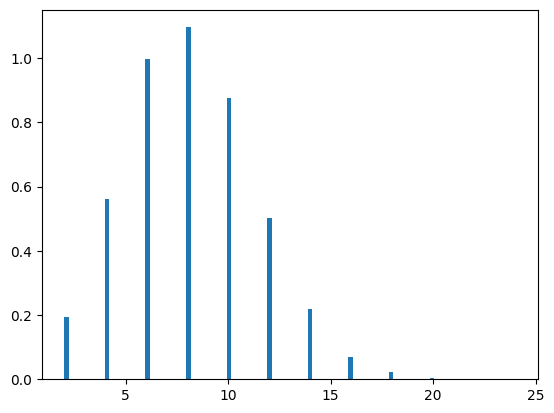

In [32]:
plt.hist(nv_lst,density=True,bins=100)
plt.show()

In [33]:
#print summary stats for distribution of particle numbers
nv_values2 = np.array(nv_lst)
meann,Delta_meann,num_obs,p_normal=comp_mean_bootstrap_uncertainty(nv_values2)
print(f"{meann=},{Delta_meann=},{num_obs=},{p_normal=}")
median = np.median(nv_values2)
q25 = np.quantile(nv_values2,0.25)
q75 = np.quantile(nv_values2,0.75)
print(f"median: {median} (IQR: {q25}-{q75}, N={nv_values2.shape[0]})")

meann=8.114300343044391,Delta_meann=0.020465343167936766,num_obs=97655,p_normal=0.5805534402402311
median: 8.0 (IQR: 6.0-10.0, N=97655)


In [34]:
nv_lst_parti = []
nobs_full = nv_values.shape[0]
nobs_parti = len(nv_lst_parti)
seed = 0
np.random.seed(seed)
while nobs_parti<nobs_full:
    seed+=1
#     Ninitial = int(np.random.choice(nv_values))
    Ninitial = N0 #2
    dictt = gener_termination_time_log(seed,Ninitial=Ninitial,Nfinal=0,
                            save_every=int(1e-2/1e-5),
                            chi=chi,kappa=kappa, #Hz
                            r=r, #cms
                            varkappa=a, #cm^2/s
                            D=D, #cm^2/s
                            Mp = Mp, # Hz/cm^2;
                            nup = nup,L=L,creation_duration = creation_duration, # 0.001 #s  # 0.1 #s
                            Dt=Dt,dt=dt,use_creation=True,use_pair_create=True,use_set_created_from_existing=True)
    t=dictt['t']
    dict_out_lst= dictt['dict_out_lst']
    df = pd.concat([pd.DataFrame(dict_out) for dict_out in dict_out_lst])
    df.reset_index(inplace=True, drop=True)
    nv_lst_parti.extend(df.groupby(by='frame')['n'].max().values)
    nobs_parti = len(nv_lst_parti)
    print(f"termination time: {t:.4f} seconds ({nobs_parti/nobs_full:.2%} obs made) ({Ninitial=}) \r", end="")

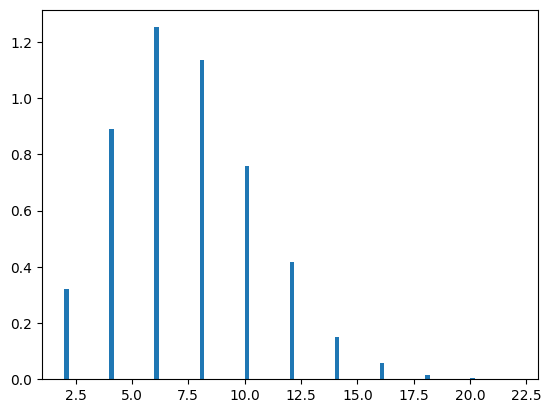

In [35]:
#29.16%
plt.hist(nv_lst_parti,bins=100, density=True)
# plt.yscale('log')
plt.show()

In [36]:
#print summary stats for distribution of particle numbers
nv_values_parti2 = np.array(nv_lst_parti)
meann,Delta_meann,num_obs,p_normal=comp_mean_bootstrap_uncertainty(nv_values_parti2)
print(f"{meann=},{Delta_meann=},{num_obs=},{p_normal=}")
median = np.median(nv_values_parti2)
q25 = np.quantile(nv_values_parti2,0.25)
q75 = np.quantile(nv_values_parti2,0.75)
print(f"median: {median} (IQR: {q25}-{q75}, N={nv_values_parti2.shape[0]})")

meann=7.354187065189384,Delta_meann=0.04544957106217582,num_obs=19405,p_normal=0.2190647932945391
median: 8.0 (IQR: 6.0-10.0, N=19405)


In [37]:
scipy.stats.mannwhitneyu(nv_values_parti2,nv_values2)

MannwhitneyuResult(statistic=816319191.0, pvalue=8.511140934245036e-212)

In [38]:
scipy.stats.kstest(nv_values_parti2,nv_values2)

KstestResult(statistic=0.10660192807077051, pvalue=1.2041806185984153e-160)

In [39]:
beep(3)

-n 
-n 
-n 


0

# save results and share with WJ

In [40]:
# from lib.utils.yamlio import *
def save_to_yaml(save_fn,mdict):
    '''saves dict instance to .yaml.

    Example Usage:
documents = save_to_yaml(input_fn,mdict)
    '''
    with open(save_fn, 'w') as file:
        documents = yaml.dump(mdict, file)
        return documents
        #return os.path.abspath(input_fn)

In [41]:
# save_to_mat
# save_
out = dict(
    n_fk = list(nv_values2),
    n_fk_lpm = list(nv_values_parti2),
    n_lr = list(nv_values),
    n_lr_lpm = list(nv_values_parti),
) 

In [42]:
# save_fn = f"{nb_dir}/data/local_results/creation_n_distrib.yaml"
# save_fn = f"{nb_dir}/data/local_results/creation_n_distrib_c.yaml"
save_fn = f"{nb_dir}/data/local_results/creation_n_distrib_c_N0_2.yaml"

In [43]:
# save_to_yaml(save_fn,out)
os.path.exists(save_fn)

False

In [44]:
save_to_mat(save_fn.replace('.yaml','.mat'),out)

'/Users/timothytyree/Documents/GitHub/bgmc/python/data/local_results/creation_n_distrib_c_N0_2.mat'